PREPARE DATASET AND FILL MISSING VALUES

In [205]:
# Necessary Libraries for the task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

In [206]:
# Reading the dataset from the given csv file
dataset = pd.read_csv(r'Downloads\modified_data.csv')
dataset.shape

(1460, 77)

In [207]:
# Checking for columns with missing values
missing_values = dataset.columns[dataset.isna().any()]
print(missing_values)

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')


In [208]:
# Percentages of missing values in the above columns
missing_columns = list(missing_values)
for column in missing_columns:
    print(column, '', (dataset[column].isna().sum())/len(dataset) * 100)

LotFrontage  17.73972602739726
MasVnrType  0.547945205479452
MasVnrArea  0.547945205479452
BsmtQual  2.5342465753424657
BsmtCond  2.5342465753424657
BsmtExposure  2.6027397260273974
BsmtFinType1  2.5342465753424657
BsmtFinType2  2.6027397260273974
Electrical  0.0684931506849315
FireplaceQu  47.26027397260274
GarageType  5.5479452054794525
GarageYrBlt  5.5479452054794525
GarageFinish  5.5479452054794525
GarageQual  5.5479452054794525
GarageCond  5.5479452054794525


In [209]:
# Drop features with more than 50% of missing values
dataset.dropna(axis=1,thresh=0.5*(len(dataset)),inplace=True)
dataset.shape
# No column is dropped

(1460, 77)

In [210]:
# Cloumns filled with mean
col_mean=['LotFrontage', 'MasVnrArea']
for column in col_mean:
    dataset[column].fillna(dataset[column].mean(),inplace=True)

In [211]:
# Columns filled using Backward fill
col_back=['FireplaceQu']
for column in col_back:
    dataset[column].fillna(method='bfill', inplace=True)

In [212]:
# Columns filled using Forward fill
col_forward=list(set(missing_columns)-set(col_mean)-set(col_back))
for column in col_forward:
    dataset[column].fillna(method='ffill', inplace=True)

In [213]:
# Checking if there are stil any missing values
dataset.isna().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 77, dtype: bool

ENCODING THE DATASET

In [214]:
# Check feature data types
dataset.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 77, dtype: object

In [215]:
# Categorical data in a list
cat_data = dataset.select_dtypes(include=['object']).copy()
cat_col = list(cat_data.columns)
original_col = list(dataset.columns)

In [216]:
# Categorizing data into nominal, ordinal and numerical
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood']
ordinal = list(set(cat_col)-set(nominal))
numerical = list(set(original_col)-set(cat_col))

In [217]:
#Target Feature
target=['SalePrice']

In [218]:
# Encoding Categorical Data
dataset['HouseStyle'].astype('category').cat.codes

0       5
1       2
2       5
3       5
4       5
       ..
1455    5
1456    2
1457    5
1458    2
1459    2
Length: 1460, dtype: int8

In [219]:
# Encoding ordinal data
for column in ordinal:
    dataset[column]=(dataset[column].astype('category')).cat.codes

df_nominal=pd.get_dummies(dataset[nominal])
df_ordinal=dataset[ordinal]
df_numerical=dataset[numerical]

In [220]:
# Putting the encoding data together
encoded_dataset=pd.concat([df_numerical, df_nominal, df_ordinal], axis=1)
encoded_dataset

,MiscVal,BsmtHalfBath,GrLivArea,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,Fireplaces,GarageCars,YearRemodAdd,MSSubClass,...,Street,FireplaceQu,GarageFinish,ExterQual,GarageType,Exterior1st,RoofStyle,Utilities,Exterior2nd,BsmtQual
0,0,0,1710,856,8,2003.0,0,2,2003,60,...,1,4,1,2,1,12,1,0,13,2
1,0,1,1262,1262,6,1976.0,1,2,1976,20,...,1,4,1,3,1,8,1,0,8,2
2,0,0,1786,920,6,2001.0,1,2,2002,60,...,1,4,1,2,1,12,1,0,13,2
3,0,0,1717,961,7,1998.0,1,3,1970,70,...,1,2,2,3,5,13,1,0,15,3
4,0,0,2198,1145,9,2000.0,1,3,2000,60,...,1,4,1,2,1,12,1,0,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1647,953,7,1999.0,1,2,2000,60,...,1,4,1,3,1,12,1,0,13,2
1456,0,0,2073,2073,7,1978.0,2,2,1988,20,...,1,4,2,3,1,9,1,0,10,2
1457,2500,0,2340,1188,9,1941.0,2,1,2006,70,...,1,2,1,0,1,5,1,0,5,3
1458,0,0,1078,1078,5,1950.0,0,1,1996,20,...,1,-1,2,3,1,8,3,0,8,3


STANDARDIZING THE DATASET

In [221]:
encoded_dataset[target]

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [222]:
# Dropping the target
x = encoded_dataset.drop('SalePrice', axis=1)
y = dataset[target]

In [223]:
# Convert data to numpy
x = x.to_numpy()
y = y.to_numpy()

In [224]:
x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

FEATURE EXTRACTION USING PCA

In [225]:
pca = PCA(n_components=2)
components = pca.fit_transform(x)

In [226]:
pca.explained_variance_ratio_

array([0.10115371, 0.0430646 ])

In [227]:
# New Dataset
pca_dataset = pd.DataFrame(components, columns=['P1', 'P2'])
target_col = pd.DataFrame(y, columns=['SalePrice'])
new_dataset = pd.concat([pca_dataset, target_col], axis=1)
new_dataset

,P1,P2,SalePrice
0,2.410793,-1.329069,0.347273
1,0.434251,2.625499,0.007288
2,2.830702,-0.853922,0.536154
3,-1.361953,0.552901,-0.515281
4,5.314195,-0.221943,0.869843
...,...,...,...
1455,1.304305,-2.292131,-0.074560
1456,1.093538,3.176652,0.366161
1457,1.257548,-0.866427,1.077611
1458,-2.832902,3.180924,-0.488523


In [228]:
x =  components

FEATURE SELECTION USING L1

In [229]:
x = encoded_dataset.drop('SalePrice', 1)
y = encoded_dataset['SalePrice']
regressor = LassoCV()
regressor.fit(X, y)
coef_col = pd.Series(regressor.coef_, index=x.columns)

C:\Users\HP\AppData\Local\Temp\ipykernel_22616\3656981051.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = encoded_dataset.drop('SalePrice', 1)


Text(0.5, 1.0, 'L1 Feature selection')

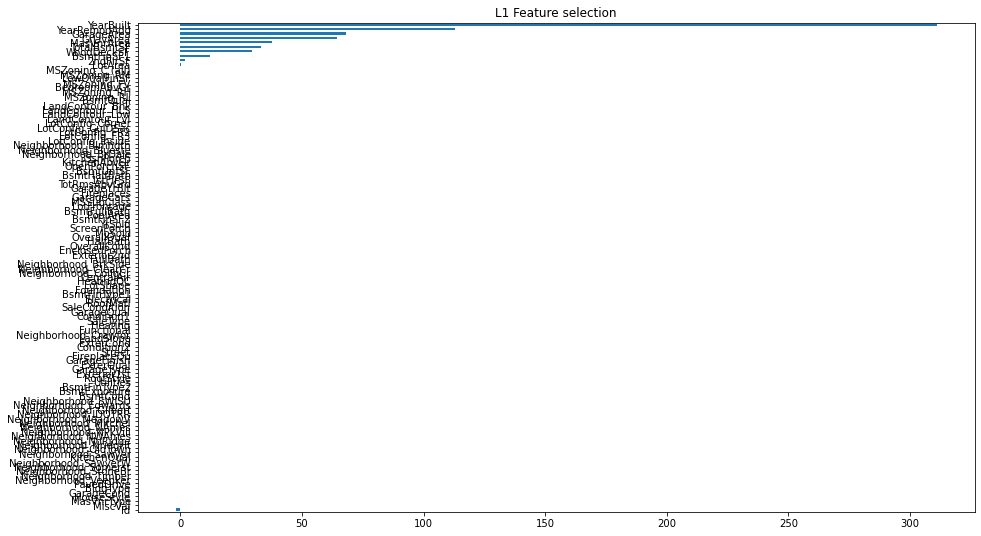

In [230]:
sorted_coef = coef_col.sort_values()
plt.rcParams['figure.figsize'] = (15.0, 9.0)
sorted_coef.plot(kind='barh')
plt.title("L1 Feature selection")

In [231]:
number_of_selected_features = sum(coef_col != 0)
number_of_rejected_features = sum(coef_col == 0)
features = number_of_selected_features + number_of_rejected_features
print(number_of_selected_features, "of", features, "features were selected and ", number_of_rejected_features, "of", features,"features were rejected")

12 of 111 features were selected and  99 of 111 features were rejected


TRAINING THE MODEL

In [232]:
x = x.to_numpy()
y = y.to_numpy()

In [233]:
target = 'SalePrice'
y = pd.DataFrame(dataset[target])

In [234]:
x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

In [235]:
pca2 = PCA(n_components=2)
components_2=pca2.fit_transform(x)

In [236]:
x = components_2

In [237]:
regressor = LassoCV()
regressor.fit(x, y)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV()

In [238]:
regressor.coef_

array([0.25351796, 0.01760871])

In [239]:
regressor.intercept_

9.177463880044703e-17

PLANE OF BEST FIT

In [240]:
pca_dataset_2 = pd.DataFrame(components_2,columns=['P1','P2'])
target = pd.DataFrame(y,columns=['SalePrice'])
new_data = pd.concat([pca_dataset_2, target],axis=1)
new_data

,P1,P2,SalePrice
0,2.410792,-1.328547,0.347273
1,0.434250,2.623919,0.007288
2,2.830701,-0.853453,0.536154
3,-1.361953,0.553710,-0.515281
4,5.314192,-0.221799,0.869843
...,...,...,...
1455,1.304306,-2.291740,-0.074560
1456,1.093539,3.175807,0.366161
1457,1.257553,-0.865980,1.077611
1458,-2.832903,3.182336,-0.488523


In [241]:
new_data_array = new_data.to_numpy()
min_value = np.min(new_data_array, axis=0)
max_value = np.max(new_data_array, axis=0)
x_plot, y_plot = np.meshgrid(np.linspace(min_value[0], max_value[0], 20), np.linspace(min_value[1], max_value[1], 20))

In [242]:
weight_1 = regressor.coef_[0]
weight_2 = regressor.coef_[1]
b = regressor.intercept_
z_plot = weight_1 * x_plot + weight_2 * y_plot + b

C:\Users\HP\AppData\Local\Temp\ipykernel_22616\1158008200.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  x_a = figure.gca(projection='3d')


Text(0.5, 0.92, 'Plane of Best Fit')

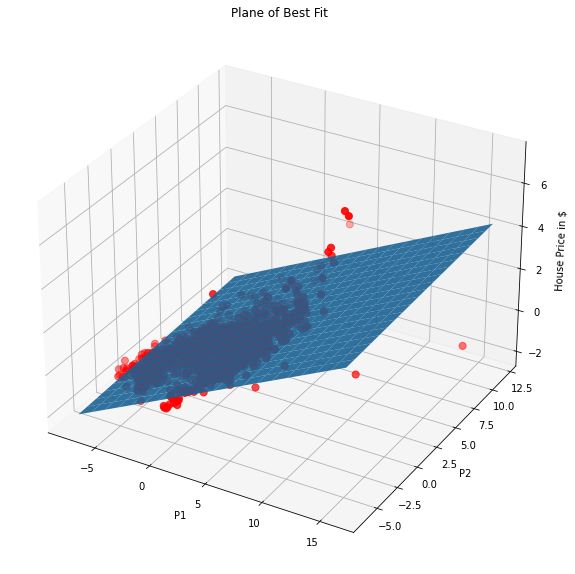

In [243]:
figure = plt.figure(figsize=(10,10))
x_a = figure.gca(projection='3d')
x_a.plot_surface(x_plot, y_plot, z_plot, rstride=1, cstride=1, alpha=0.9)
x_a.scatter(new_data_array[:,0], new_data_array[:,1], new_data_array[:,2], c='r', s=50)
plt.xlabel('P1')
plt.ylabel('P2')
x_a.set_zlabel('House Price in $')
x_a.set_title("Plane of Best Fit")